#Dissipative Driven Entanglement Notebook
Author: Eugene Dumitrescu

In this notebook we (loosely) follow the prescription of Refs[1,2] to simulate the dynamical entanglement of QD systems coupled to a quantum environment. The approach taken is based on cavity QED, however our aim is to replace the cavity with a plasmonic reservoir.

### References
* [M. Otten, R. A. Shah, N. F. Scherer, M. Min, M. Pelton, and S. K. Gray, Phys. Rev. B 92, 125432 (2015)](http://journals.aps.org/prb/abstract/10.1103/PhysRevB.92.125432)
* [Dissipation-driven entanglement between qubits mediated by plasmonic nanoantennas](http://journals.aps.org/prb/abstract/10.1103/PhysRevB.89.235413)


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from qutip import *
import scipy.signal as ss

# operators acting on the composite spin-boson Hilbert space
def I(N,M):
    """Identity"""
    oplist = [qeye(2)] * N
    oplist.append(qeye(M))
    return tensor(oplist)

# spin operators
def sx(i, N, M):
    """Pauli X on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmax()
    oplist.append(qeye(M))
    return tensor(oplist)

def sy(i, N, M):
    """Pauli Y on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmay()
    oplist.append(qeye(M))
    return tensor(oplist)

def sz(i, N, M):
    """Pauli Z on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmaz()
    oplist.append(qeye(M))
    return tensor(oplist)

def sm(i, N, M):
    """destroy quanta on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmam()
    oplist.append(qeye(M))
    return tensor(oplist)

def sp(i, N, M):
    """create quanta on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmap()
    oplist.append(qeye(M))
    return tensor(oplist)

def d(i,N,M):
    """dipole operator for ith spin"""
    return sp(i, N, M) + sm(i, N, M)

# plasmon / EM mode operators
def a(N, M):
    """bosonic annihiliation operator"""
    oplist = [qeye(2)] * N
    oplist.append(destroy(M))
    return tensor(oplist)

def n_a(N,M):
    """bosonic number operator"""
    return a(N,M).dag() * a(N,M)

def d_a(N,M):
    """bosonic dipole operator"""
    return a(N,M).dag() + a(N,M)

# spin subspace projection operators 
def P_S(N,M):
    """Symmetric |s = 1, m_l = 0> subspace projector"""
    return .25 * (I(N,M) - sz(0,N,M) * sz(1,N,M) + sx(0,N,M) * sx(1,N,M) + sy(0,N,M) * sy(1,N,M))

def P_A(N,M):
    """Anti-symmetric |s = 0, m_l = 0> subspace projector"""
    return .25 * (I(N,M) - sz(0,N,M) * sz(1,N,M) - sx(0,N,M) * sx(1,N,M) - sy(0,N,M) * sy(1,N,M))

def P_pp(N,M):
    """|++> subspace projector """
    return np.prod([sp(i,N,M) * sm(i,N,M)  for i in range(N)])

def P_mm(N,M):
    """|--> subspace projector """
    return np.prod([sm(i,N,M) * sp(i,N,M)  for i in range(N)])


## Hamiltonian and Model

Our model Hamiltonian for a N two levels systems (TLS) interacting with a bosonic reservoir is 
<center> $H = H_0 + H_{int} + H_{drv}$ </center>
where the individual, interacting, and driving components of the Hamiltonian are given by 
<center>
$\displaystyle H_0 = - \omega_0 \sum_{i=1}^N \sigma_z^{(i)} + \omega_c a^\dagger a$
</center>
<center>
$\displaystyle H_{int} = - \sum_{i}^N g_i (\sigma^{+}a + \sigma^{-}a^\dagger)$
</center>
<center>
$\displaystyle H_{drv} = - \sum_{i}^N \Omega_i \hat{d}_i + \Omega_a \hat{d}_a$
</center>
We have used the EM field and TLS dipole operators $\hat{d}_i = \sigma^+_{(i)}+\sigma^-_{(i)}$ and $\hat{d}_a = a + a^\dagger$  in the driving term and we have also applied the rotating wave approximation.

In [2]:
N = 2          # Number of spin 1/2's
M = 3          # Number of cavity modes
lam = 2        # constant that all other constants are given in terms of

ws = [0.020, -0.020, 0.0]    # frequency/level spacing of each individual system
gs = [0.1, 0.1]              # position dependent couplings
ds = [0.1, 0.1, 0]           # driving strengths qb0,1, bosons 

def Ham(ws,gs,ds):
    """ Define the Hamiltonian as a sum over:

    Terms
    -----
    H_0: non-interacting systems
    H_RWA: interaction between subsystems in the rotating wave approximation
    H_DRV: driving terms in the co-rotating reference frame
    
    Returns
    -------
    
    Hermitial Hamiltonian operator
    H_0 - H_RWA - H_DRV
    """
    H_0   = sum(ws[i] * sp(i,N,M) * sm(i,N,M) for i in range(N)) + ws[N] * n_a(N,M)
    H_RWA = sum(gs[i] * (a(N,M) * sp(i,N,M) + a(N,M).dag() * sm(i,N,M)) for i in range(N))
    H_DRV = sum(ds[i] * d(i,N,M) for i in range(N)) + ds[N] * d_a(N,M)
    return H_0 - H_RWA - H_DRV

# Lindblad dissipation parameters
kap   = 1 * lam           # cavity relaxation rate
gam   = 1 * kap / 1e8     # atom relaxation rate
gdph  = 2 * kap / 1e8     # atom dephasing rate 
n_th  = 0.0               # thermal cavity occupation number 

def cops(kappa, gamma, deph, n_th):
    """
    Define collapse operators for Lindblad master equation
    
    Parameters
    ----------
    kappa: cavity relaxation rate,  ~ 500 THz ~ 2 eV
    gamma: emitter relaxation rate, ~ 10 MHz ~ 1mueV
    gdph: emitter dephasing rate,   ~ same as relaxation rate
    n_th: temperature for entire system, gives excitation rate

    Returns
    -------
    c_ops: list of collapse operators
    """
    c_ops = []
    for i in range(2):
        rate = np.sqrt(gamma * (1 + n_th))
        if rate > 0.0:
            c_ops.append(rate * sm(i,N,M))        # relaxation
        rate = gamma * n_th
        if rate > 0.0:
            c_ops.append(rate * sm(i,N,M).dag())  # excitation
        c_ops.append(np.sqrt(deph) * sz(i,N,M))   # dephasing  
    rate = np.sqrt(kappa * (n_th + 1))
    if rate > 0: 
        c_ops.append(rate * a(N,M))
    rate = np.sqrt(kappa * (n_th))
    if rate > 0: 
        c_ops.append(rate * a(N,M).dag())
    return c_ops

def g2(sta, ham, lin, tim):
    """
    Parameters
    ----------
    sta: initial state to evolve according to 
    ham: Hamiltonian matrix and 
    lin: Limbladian operators for 
    tim: times 
    
    Returns
    -------
    g^(2)(tau) second order correlation function
    """
    e_ss_ops = [sp(i,N,M) * sm(i,N,M) for i in range(N)]        # qubit occupation number operators
    
    rho_ae = [sm(i,N,M) * sta * sp(i,N,M) for i in range(N)]    # track all possible emission events
#   rho_ae = [r/r.tr() for r in rho_ae]                         # renormalize states
    
    # solve for <sp*sm> with respect to the post emission state
    results = [mesolve(ham, r, taus, lin, e_ss_ops) for r in rho_ae]
    
    # steady state g2 denominator/normalization constants
    denoms = [np.real((e * sta).tr()) for e in e_ss_ops]  
    return sum(results[i].expect[j] / (denoms[i] * denoms[j]) / float(N**2) for i in range(N) for j in range(N))


# Finite Delay characteristic anti-bunching timescales

It is difficult to identify the full-width half maximum because the maximum may actually occur at relaxation timescales. That is, no local maxima from "beading" is seen before the onset of long time relaxation -- back to unity as required in the long time limit. This means that the driving frequency is masked by the relaxation frequency. However we can still try to extract this feature by Fourier forming the transient signal and extracting the effectiv Rabi driving frequency numerically.  

We study the anti-bunching lifetime as a function of:
1. Detuning
2. Coupling strength
3. Driving amplitude -- good lead. This seems to be effective



### Frequency phase diagrams

The dissipative generation of a robust enagned steady state is well established but, as discussed previously, a simple robust verification thereof is lacking. 
It has previously been hypothesized that the second order correlation function could be used as 'the smoking gun' signature for this entanglement. 
The $g^{(2)}(\tau)$ details vary depending on the propasal. 

Standard DDE protocls generate the anti-symmetric bell state ($|T\rangle = |01\rangle + |10\rangle$). 
Such a state must act as a single quantum emitter with an anti-bunching signature as discussed in (Garcia-Vidal_2011).
While extremely promising, this feasability of detecting this effect far from established due to the fast timescales involved in plasmonic systems. 

Below, we explicitely consider this problem and show that the effective Rabi frequency driving the 

some experimental details of time scales are unknown.
Our goal is to ascertain what physical constants lead to an easily observed anti-bunching effect.

# Complete Analysis
of the following results:
1. Concurrence
2. Zero delay anti-bunching
3. Rabi frequency (and therefore timescales)
Goal is to put everything in the same place for clarity. 

The code panels below analyze:
1. Detunings
2. Coupligs
3. Drivings ()

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:24: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


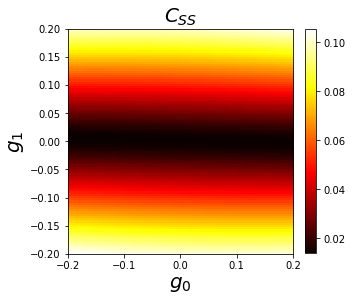

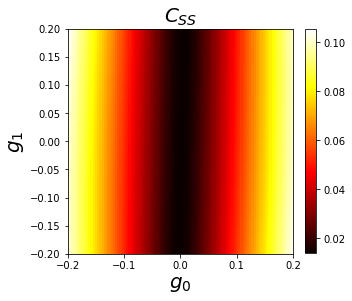

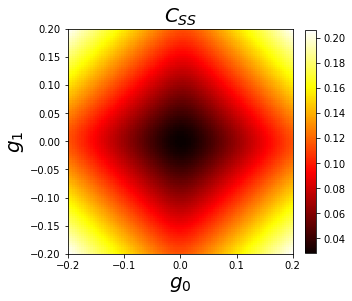

In [41]:
N = 2          # Number of spin 1/2's
M = 3          # Number of cavity modes

ws = [0.02, -0.02, 0.0]      # frequency/level spacing of each individual system
gs = [0.01, 0.01]              # position dependent couplings
ds = [0.01, 0.01, 0]           # driving strengths qb0,1, bosons 

# Lindblad collapse operators defined way above
cps = cops(kap, gam, gdph, n_th)

# detuning range
N_w = 101
w_r = 0.2
x_range = np.linspace(-w_r,w_r,N_w)
y_range = np.linspace(-w_r,w_r,N_w)

rabi0_fr = np.zeros((N_w,N_w))
rabi1_fr = np.zeros((N_w,N_w))
rabi_eff_fr = np.zeros((N_w,N_w))

# discretized g2 time domain
steps = 2e3
tmax = 5e3
taus = np.linspace(0, tmax, steps)

# make 2D 'phase diagram'
for x_i in range(N_w):
    for y_i in range(N_w):
        
        gs[0] =  x_range[x_i]
        gs[1] = y_range[::-1][y_i]
        
        beta0 = (ws[0] + 1j * kap)
        beta1 = (ws[1] + 1j * kap)

        del0_eff = (ws[0] + gs[0] * gs[1]) / beta
        del1_eff = (ws[1] + gs[0] * gs[1]) / beta

        eta0_eff = ds[0] + gs[0] / beta
        eta1_eff = ds[1] + gs[1] / beta
        
        rabi0_fr[x_i, y_i] = np.sqrt(np.abs(del0_eff)**2 + np.abs(eta0_eff)**2)
        rabi1_fr[x_i, y_i] = np.sqrt(np.abs(del1_eff)**2 + np.abs(eta1_eff)**2)      
        
        rabi_eff_fr[x_i, y_i] = np.sqrt(np.abs(del0_eff)**2 + np.abs(eta0_eff)**2) + np.sqrt(np.abs(del1_eff)**2 + np.abs(eta1_eff)**2)      

minx = min(x_range)
maxx = max(x_range)
miny = min(y_range)
maxy = max(y_range)

fs = str(20)

fig, ax = plt.subplots(1, figsize = (5,5))
im00 = ax.imshow(rabi0_fr, cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax.set_title('$C_{SS}$', fontsize = fs)
ax.set_xlabel('$g_0$', fontsize = fs)
ax.set_ylabel('$g_1$', fontsize = fs)
fig.colorbar(im00, ax = ax, fraction = 0.045)
plt.tight_layout()

fig, ax = plt.subplots(1, figsize = (5,5))
im00 = ax.imshow(rabi1_fr, cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax.set_title('$C_{SS}$', fontsize = fs)
ax.set_xlabel('$g_0$', fontsize = fs)
ax.set_ylabel('$g_1$', fontsize = fs)
fig.colorbar(im00, ax = ax, fraction = 0.045)
plt.tight_layout()

fig, ax = plt.subplots(1, figsize = (5,5))
im00 = ax.imshow(rabi_eff_fr, cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax.set_title('$C_{SS}$', fontsize = fs)
ax.set_xlabel('$g_0$', fontsize = fs)
ax.set_ylabel('$g_1$', fontsize = fs)
fig.colorbar(im00, ax = ax, fraction = 0.045)
plt.tight_layout()

In [25]:
rabi0_fr

array([[ 0.12252538,  0.12252538,  0.12252538, ...,  0.12252538,
         0.12252538,  0.12252538],
       [ 0.12163167,  0.12163167,  0.12163167, ...,  0.12163167,
         0.12163167,  0.12163167],
       [ 0.12078298,  0.12078298,  0.12078298, ...,  0.12078298,
         0.12078298,  0.12078298],
       ..., 
       [ 0.1244439 ,  0.1244439 ,  0.1244439 , ...,  0.1244439 ,
         0.1244439 ,  0.1244439 ],
       [ 0.12546671,  0.12546671,  0.12546671, ...,  0.12546671,
         0.12546671,  0.12546671],
       [ 0.12653053,  0.12653053,  0.12653053, ...,  0.12653053,
         0.12653053,  0.12653053]])

In [5]:
eta_eff


(0.095012468827930185-0.099750623441396513j)

In [8]:
del_eff**2

(-0.0020098755604753705+0.00020149128425818249j)